# Laboratorio 3: Programación Concurrente con Pthreads

## Información de los Estudiantes

Jair Santiago Leal Miranda 1000293157
Andres Guillermo Toloza Guzman 1004843452

**Nota:** video  https://drive.google.com/file/d/1pq0IdwHQPRVrIlmNMt-vZlEAmCFTK-0A/view?usp=sharing

---

Este notebook contiene el análisis de los resultados obtenidos en las dos partes del laboratorio:
- Parte 1: Paralelización del cálculo de π
- Parte 2: Generador de secuencia de Fibonacci


In [18]:
# Instalar pandas y numpy si no están instalados
%pip install pandas numpy matplotlib


     ---------------------------------------- 0.0/115.4 kB ? eta -:--:--
     --------------------------------- ---- 102.4/115.4 kB 2.0 MB/s eta 0:00:01
     -------------------------------------- 115.4/115.4 kB 1.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
    --------------------------------------- 0.2/11.3 MB 4.8 MB/s eta 0:00:03
   - -------------------------------------- 0.5/11.3 MB 5.7 MB/s eta 0:00:02
   --- ------------------------------------ 1.1/11.3 MB 7.7 MB/s eta 0:00:02
   ----- ---------------------------------- 1.6/11.3 MB 8.7 MB/s eta 0:00:02
   ------ --------------------------------- 1.9/11.3 MB 9.3 MB/s eta 0:00:02
   ------ --------------------------------- 1.9/11.3 MB 9.3 MB/s eta 0:00:02
   ---------- ----------------------------- 3.0/11.3 MB 9.5 MB/s eta 0:00:01
   ------------ --------------------------- 3.5/11.3 MB 9.7 MB/s eta 0:00:01
   -------------- ------------------------- 4.0/11.3 MB 9.9 MB/s eta 0:00:01
   -


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\santi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Sección 1: Análisis de π

En esta sección se analiza el rendimiento de la paralelización del cálculo de π usando integración numérica.


### 1.1 Evaluación del Tiempo Serial (Ts)

Ejecutando el programa `./pi_s` con n = 2000000000 intervalos para obtener el tiempo serial.


In [11]:
import subprocess
import re
import os
import sys

# Detectar directorio src y si usar WSL
current_dir = os.getcwd()
src_dir = current_dir if os.path.basename(current_dir) == 'src' else os.path.join(current_dir, 'src')
usar_wsl = sys.platform.startswith('win') and not os.path.exists(os.path.join(src_dir, 'pi_s.exe'))

if usar_wsl:
    ruta_wsl = src_dir.replace('\\', '/').replace('C:', '/mnt/c').replace('c:', '/mnt/c')

print("Ejecutando ./pi_s...")

try:
    if usar_wsl:
        comando = ['wsl', 'bash', '-c', f'cd {ruta_wsl} && ./pi_s']
    else:
        comando = [os.path.join(src_dir, 'pi_s')]
    
    result = subprocess.run(comando, capture_output=True, text=True, timeout=300)
    match = re.search(r'Time elapsed:\s+([\d.]+)\s+seconds', result.stdout)
    
    if match:
        Ts = float(match.group(1))
        print(f"Tiempo Serial (Ts): {Ts:.6f} segundos")
    else:
        print("Error: No se pudo extraer el tiempo")
        print(result.stdout)
        Ts = None
        
except Exception as e:
    print(f"Error: {e}")
    Ts = None


Ejecutando ./pi_s...
Tiempo Serial (Ts): 6.979937 segundos


### 1.2 Evaluación de Tiempos Paralelos (Tp)

Ejecutando el programa `./pi_p` con el mismo n = 2000000000, variando el número de hilos.


In [24]:
# Números de hilos a probar
num_hilos_lista = [1, 2, 4, 8]
tiempos_paralelos = {}

# Detectar si usar WSL (ejecutables de Linux en Windows)
current_dir = os.getcwd()
src_dir = current_dir if os.path.basename(current_dir) == 'src' else os.path.join(current_dir, 'src')
usar_wsl = sys.platform.startswith('win') and not os.path.exists(os.path.join(src_dir, 'pi_p.exe'))

if usar_wsl:
    ruta_wsl = src_dir.replace('\\', '/').replace('C:', '/mnt/c').replace('c:', '/mnt/c')

print("Ejecutando ./pi_p con diferentes números de hilos...\n")

for num_hilos in num_hilos_lista:
    print(f"Ejecutando con {num_hilos} hilo(s)...", end=' ')
    
    try:
        if usar_wsl:
            comando = ['wsl', 'bash', '-c', f'cd {ruta_wsl} && ./pi_p {num_hilos}']
        else:
            comando = [os.path.join(src_dir, 'pi_p'), str(num_hilos)]
        
        result = subprocess.run(comando, capture_output=True, text=True, timeout=300)
        match = re.search(r'Time elapsed:\s+([\d.]+)\s+seconds', result.stdout)
        
        if match:
            tiempo = float(match.group(1))
            tiempos_paralelos[num_hilos] = tiempo
            print(f"{tiempo:.6f} segundos")
        else:
            print("Error: No se pudo extraer el tiempo")
            
    except Exception as e:
        print(f"Error: {e}")

print("\nResumen de Tiempos Paralelos (Tp):")
for hilos, tiempo in sorted(tiempos_paralelos.items()):
    print(f"  {hilos} hilo(s): {tiempo:.6f} segundos")


Ejecutando ./pi_p con diferentes números de hilos...

Ejecutando con 1 hilo(s)... 7.390469 segundos
Ejecutando con 2 hilo(s)... 3.778186 segundos
Ejecutando con 4 hilo(s)... 1.957459 segundos
Ejecutando con 8 hilo(s)... 1.224914 segundos

Resumen de Tiempos Paralelos (Tp):
  1 hilo(s): 7.390469 segundos
  2 hilo(s): 3.778186 segundos
  4 hilo(s): 1.957459 segundos
  8 hilo(s): 1.224914 segundos


### 1.3 Tabla de Resultados

A continuación se presenta la tabla con las métricas de rendimiento calculadas.


In [2]:
import pandas as pd
import numpy as np

# Verificar que tenemos el tiempo serial
if Ts is None:
    print("Error: No se pudo obtener el tiempo serial. Ejecuta primero la celda anterior.")
else:
    # Preparar datos de los experimentos
    hilos_lista = sorted(tiempos_paralelos.keys())
    tiempos_lista = [tiempos_paralelos[h] for h in hilos_lista]
    
    # Calcular Speedup y Eficiencia
    speedups = [Ts / tp for tp in tiempos_lista]
    eficiencias = [s / n for s, n in zip(speedups, hilos_lista)]
    
    # Crear diccionario de datos
    datos = {
        'N (Hilos)': hilos_lista,
        'Tp (segundos)': tiempos_lista,
        'Speedup (Ts/Tp)': speedups,
        'Eficiencia (Speedup/N)': eficiencias
    }
    
    # Crear DataFrame
    df = pd.DataFrame(datos)
    
    # Crear una copia formateada para mostrar
    df_mostrar = df.copy()
    df_mostrar['Tp (segundos)'] = df_mostrar['Tp (segundos)'].apply(lambda x: f"{x:.6f}")
    df_mostrar['Speedup (Ts/Tp)'] = df_mostrar['Speedup (Ts/Tp)'].apply(lambda x: f"{x:.3f}")
    df_mostrar['Eficiencia (Speedup/N)'] = df_mostrar['Eficiencia (Speedup/N)'].apply(lambda x: f"{x:.3f}")
    
    print("Tabla de Resultados:")
    print(df_mostrar.to_string(index=False))
    
    # Guardar el DataFrame original para usar en el gráfico
    display(df)


NameError: name 'Ts' is not defined

### 1.4 Gráfico de Speedup

Gráfico de líneas mostrando la relación entre el número de hilos y el speedup obtenido.


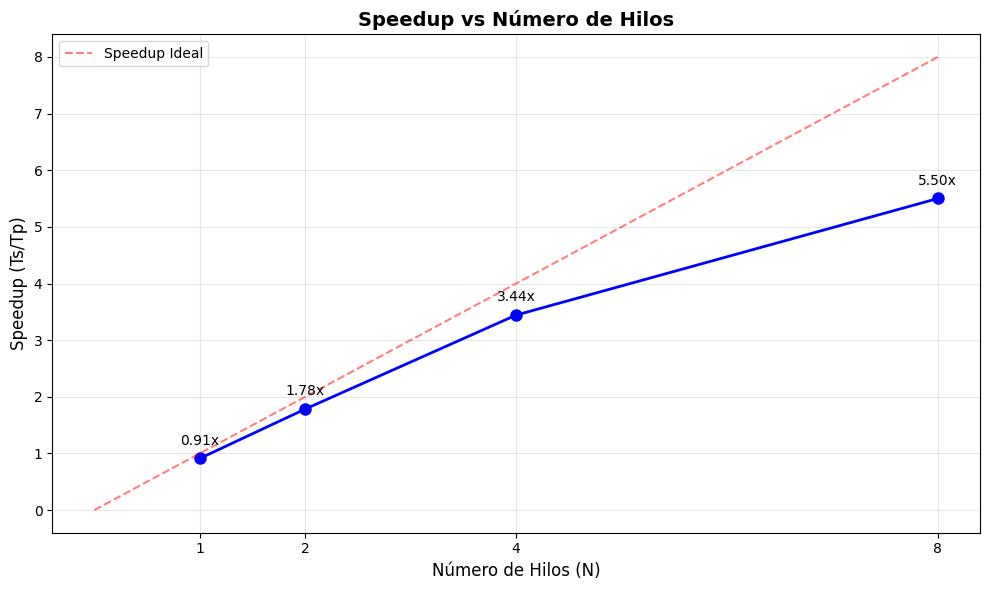

In [26]:
import matplotlib.pyplot as plt

# Verificar que tenemos los datos necesarios
if Ts is None or not tiempos_paralelos:
    print("Error: No se tienen los datos necesarios. Ejecuta primero las celdas anteriores.")
else:
    # Datos para el gráfico
    hilos = sorted(tiempos_paralelos.keys())
    speedups = [Ts / tiempos_paralelos[h] for h in hilos]
    
    # Crear el gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(hilos, speedups, marker='o', linewidth=2, markersize=8, color='blue')
    plt.xlabel('Número de Hilos (N)', fontsize=12)
    plt.ylabel('Speedup (Ts/Tp)', fontsize=12)
    plt.title('Speedup vs Número de Hilos', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.xticks(hilos)
    
    # Línea de referencia para speedup ideal (línea diagonal)
    max_hilos = max(hilos)
    plt.plot([0, max_hilos], [0, max_hilos], 'r--', alpha=0.5, label='Speedup Ideal')
    plt.legend()
    
    # Agregar valores en los puntos
    for h, s in zip(hilos, speedups):
        plt.annotate(f'{s:.2f}x', (h, s), textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.tight_layout()
    plt.show()


### 1.5 Análisis de Resultados (Parte 1)

A continuación se presenta el análisis de los resultados obtenidos.


In [27]:
# Análisis automático de los resultados
if Ts is None or not tiempos_paralelos:
    print("Error: No se tienen los datos necesarios. Ejecuta primero las celdas anteriores.")
else:
    print("=" * 70)
    print("ANÁLISIS DE RESULTADOS")
    print("=" * 70)
    
    # Comparación Tp(1) vs Ts
    if 1 in tiempos_paralelos:
        Tp1 = tiempos_paralelos[1]
        diferencia = Tp1 - Ts
        porcentaje = (diferencia / Ts) * 100
        
        print(f"\n1. Comparación entre Tp(1) y Ts:")
        print(f"   - Tiempo Serial (Ts): {Ts:.6f} segundos")
        print(f"   - Tiempo Paralelo con 1 hilo (Tp(1)): {Tp1:.6f} segundos")
        print(f"   - Diferencia: {diferencia:.6f} segundos ({porcentaje:.2f}% más lento)")
        
        if Tp1 > Ts:
            print(f"\n   El tiempo paralelo con 1 hilo es mayor que el tiempo serial.")
            print(f"   Esta discrepancia se debe al overhead introducido por:")
            print(f"   - Creación de la estructura de datos para el hilo")
            print(f"   - Llamada a pthread_create para crear el hilo")
            print(f"   - Llamada a pthread_join para esperar su finalización")
            print(f"   - Gestión de memoria adicional")
            print(f"   Este overhead es pequeño pero medible.")
    
    # Speedup máximo
    speedups_calc = {h: Ts / t for h, t in tiempos_paralelos.items()}
    max_speedup_hilos = max(speedups_calc, key=speedups_calc.get)
    max_speedup_valor = speedups_calc[max_speedup_hilos]
    
    print(f"\n2. Análisis del Speedup Máximo:")
    print(f"   - Speedup máximo: {max_speedup_valor:.3f}x con {max_speedup_hilos} hilo(s)")
    print(f"   - Speedup ideal con {max_speedup_hilos} hilos: {max_speedup_hilos:.1f}x")
    print(f"   - Eficiencia del speedup máximo: {(max_speedup_valor/max_speedup_hilos)*100:.1f}%")
    print(f"\n   Para comparar esto con el número de núcleos físicos del sistema,")
    print(f"   sería necesario conocer la configuración del hardware.")
    print(f"   El speedup ideal sería {max_speedup_hilos}x con {max_speedup_hilos} hilos,")
    print(f"   pero factores como overhead de sincronización, contención de memoria,")
    print(f"   y límites del hardware impiden alcanzar este valor teórico.")
    
    # Tendencia de eficiencia
    print(f"\n3. Tendencia de la Eficiencia:")
    print(f"   {'Hilos':<8} {'Tiempo (s)':<15} {'Speedup':<12} {'Eficiencia':<12}")
    print(f"   {'-'*8} {'-'*15} {'-'*12} {'-'*12}")
    
    for hilos in sorted(tiempos_paralelos.keys()):
        tiempo = tiempos_paralelos[hilos]
        speedup = speedups_calc[hilos]
        eficiencia = speedup / hilos
        print(f"   {hilos:<8} {tiempo:<15.6f} {speedup:<12.3f} {eficiencia:<12.3f} ({eficiencia*100:.1f}%)")
    
    print(f"\n   Causas del comportamiento:")
    print(f"   1. Overhead de sincronización: El costo de crear, gestionar y")
    print(f"      sincronizar hilos aumenta con más hilos.")
    print(f"   2. Contención de recursos: Múltiples hilos compiten por acceso")
    print(f"      a memoria compartida, creando cuellos de botella.")
    print(f"   3. Límites del hardware: Si el número de hilos excede el número")
    print(f"      de núcleos físicos, el SO debe hacer time-slicing.")
    print(f"   4. Overhead de comunicación: La recolección de resultados y")
    print(f"      gestión de memoria tienen un costo que aumenta con más hilos.")
    
    print(f"\n   La eficiencia disminuye porque el overhead crece más rápido")
    print(f"   que la ganancia de paralelismo, especialmente cuando se supera")
    print(f"   el número óptimo de hilos para el hardware disponible.")
    
    print("\n" + "=" * 70)


ANÁLISIS DE RESULTADOS

1. Comparación entre Tp(1) y Ts:
   - Tiempo Serial (Ts): 6.738720 segundos
   - Tiempo Paralelo con 1 hilo (Tp(1)): 7.390469 segundos
   - Diferencia: 0.651749 segundos (9.67% más lento)

   El tiempo paralelo con 1 hilo es mayor que el tiempo serial.
   Esta discrepancia se debe al overhead introducido por:
   - Creación de la estructura de datos para el hilo
   - Llamada a pthread_create para crear el hilo
   - Llamada a pthread_join para esperar su finalización
   - Gestión de memoria adicional
   Este overhead es pequeño pero medible.

2. Análisis del Speedup Máximo:
   - Speedup máximo: 5.501x con 8 hilo(s)
   - Speedup ideal con 8 hilos: 8.0x
   - Eficiencia del speedup máximo: 68.8%

   Para comparar esto con el número de núcleos físicos del sistema,
   sería necesario conocer la configuración del hardware.
   El speedup ideal sería 8x con 8 hilos,
   pero factores como overhead de sincronización, contención de memoria,
   y límites del hardware impiden 

## Sección 2: Análisis de Fibonacci

En esta sección se analiza la implementación del generador de secuencia de Fibonacci usando hilos.


### 2.1 Resultados de Ejecución

Salida del programa `./fibonacci 15`:


In [13]:
# Ejecutar el programa fibonacci con 15 elementos
current_dir = os.getcwd()
src_dir = current_dir if os.path.basename(current_dir) == 'src' else os.path.join(current_dir, 'src')
usar_wsl = sys.platform.startswith('win') and not os.path.exists(os.path.join(src_dir, 'fibonacci.exe'))

numero_elementos = 10

print("Ejecutando ./fibonacci", numero_elementos, "...")



try:
    if usar_wsl:
        # Convertir ruta de Windows a WSL de forma más robusta
        ruta_wsl = src_dir.replace('\\', '/')
        # Convertir C: o c: a /mnt/c
        if ruta_wsl.startswith('C:/') or ruta_wsl.startswith('c:/'):
            ruta_wsl = '/mnt/c' + ruta_wsl[2:]
        elif not ruta_wsl.startswith('/'):
            # Si no empieza con /, asumir que es C:
            ruta_wsl = '/mnt/c' + ruta_wsl
        
        # Usar ruta absoluta del ejecutable
        fib_path = f"{ruta_wsl}/fibonacci"
        comando = ['wsl', 'bash', '-c', f'cd {ruta_wsl} && ls -la fibonacci && ./fibonacci {numero_elementos}']
    else:
        comando = [os.path.join(src_dir, 'fibonacci'), str(numero_elementos)]
    
    result = subprocess.run(comando, capture_output=True, text=True, timeout=60)
    
    if result.returncode == 0:
        print("Salida del programa:")
        print(result.stdout)
    else:
        print("Error al ejecutar el programa:")
        if result.stderr:
            print(result.stderr)
        print("\nSalida:")
        print(result.stdout)
        if usar_wsl:
            print(f"\nDebug: Ruta WSL intentada: {ruta_wsl}")
        
except Exception as e:
    print(f"Error: {e}")

Ejecutando ./fibonacci 10 ...
Salida del programa:
-rwxrwxrwx 1 jair jair 16416 Nov 28 15:29 fibonacci
Secuencia de Fibonacci (primeros 10 elementos):
0 1 1 2 3 5 8 13 21 34



### 2.2 Análisis del Diseño (Parte 2)

#### Mecanismo de Transferencia de Datos
per
El mecanismo utilizado para transferir datos del hilo principal al hilo trabajador se basa en una estructura de datos (`fibonacci_args_t`) que contiene:

- **Puntero al arreglo compartido** (`long long* array`): Este puntero apunta a la memoria dinámica asignada por el hilo principal usando `malloc`. El arreglo es compartido entre ambos hilos, permitiendo que el hilo trabajador escriba los resultados y que el hilo principal los lea después.

- **Número de elementos** (`int n`): Indica cuántos números de Fibonacci deben generarse.

El proceso funciona de la siguiente manera:

1. El hilo principal (`main`) asigna memoria dinámica para el arreglo usando `malloc(n * sizeof(long long))`.

2. Se crea una instancia de la estructura `fibonacci_args_t` y se inicializa con el puntero al arreglo y el valor de N.

3. Esta estructura se pasa como argumento a `pthread_create()` cuando se crea el hilo trabajador.

4. El hilo trabajador recibe este argumento como un puntero genérico (`void*`), lo convierte al tipo correcto (`fibonacci_args_t*`), y accede a los datos.

5. El hilo trabajador escribe directamente en el arreglo compartido usando el puntero recibido.

Este mecanismo es eficiente porque no requiere copiar datos grandes, solo se pasa un puntero (8 bytes en sistemas de 64 bits) y un entero (4 bytes).

#### Rol de pthread_join como Mecanismo de Sincronización

`pthread_join` juega un papel crítico como mecanismo de sincronización en este problema. Su función principal es:

1. **Garantizar la finalización del hilo trabajador**: `pthread_join` bloquea el hilo principal hasta que el hilo trabajador especificado termine su ejecución completamente.

2. **Asegurar la integridad de los datos**: Sin `pthread_join`, el hilo principal podría intentar leer el arreglo compartido antes de que el hilo trabajador termine de calcular y escribir todos los valores. Esto resultaría en:
   - Valores no inicializados (si el hilo principal lee antes de que se escriban)
   - Valores parcialmente calculados (si el hilo principal lee mientras el trabajador está escribiendo)
   - Comportamiento indefinido y resultados incorrectos

3. **Ordenar la ejecución**: `pthread_join` establece un orden claro: primero el hilo trabajador calcula todos los valores, luego el hilo principal los imprime. Esto crea una relación de dependencia temporal que garantiza la corrección del programa.

4. **Prevenir race conditions**: Aunque en este caso específico el hilo trabajador solo escribe y el principal solo lee (después de join), `pthread_join` asegura que no haya condiciones de carrera al garantizar que todas las escrituras terminen antes de cualquier lectura.

En resumen, `pthread_join` actúa como una barrera de sincronización que asegura que el hilo principal no acceda a los resultados hasta que el hilo trabajador haya completado su trabajo y todos los datos estén listos para ser leídos de forma segura.
